#### Import all the Libraries used

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.7 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np

#for visualisations of graphs
import matplotlib.pyplot as plt 
%matplotlib inline

#for datetime object
from datetime import datetime 

#statsmodel libraires
from statsmodels.tsa.stattools import adfuller                 #To check stationarity in Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX         #SARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing   #Holt's Winter Method

#ARIMA
from pmdarima import auto_arima

#Skit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('my_data.csv')

In [5]:
df.head()

,YEAR,MONTH,DAY,STID,RAIN
0,2007,4,20,OKCE,0.00
1,2007,4,21,OKCE,0.00
2,2007,4,22,OKCE,0.00
3,2007,4,23,OKCE,0.00
4,2007,4,24,OKCE,0.21


In [6]:
df['DATE'] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY))

In [7]:
df.head()

,YEAR,MONTH,DAY,STID,RAIN,DATE
0,2007,4,20,OKCE,0.00,2007-04-20
1,2007,4,21,OKCE,0.00,2007-04-21
2,2007,4,22,OKCE,0.00,2007-04-22
3,2007,4,23,OKCE,0.00,2007-04-23
4,2007,4,24,OKCE,0.21,2007-04-24


In [8]:
df2 = df.copy()

In [9]:
#Drop year and month column
data  = df2.drop(['YEAR', 'MONTH','DAY','STID'], axis=1)

In [10]:
#Check object types
data.dtypes

RAIN           float64
DATE    datetime64[ns]
dtype: object

In [11]:
#convert object dtype to datetime
data['DATE'] = pd.to_datetime(data.DATE,format='%d-%m-%Y')

In [12]:
#create months column
data['MONTH'] = data['DATE'].dt.month

In [13]:
#check object type
data.dtypes

RAIN            float64
DATE     datetime64[ns]
MONTH             int64
dtype: object

### Plot cummulative monthly rainfall

<Axes: xlabel='MONTH'>

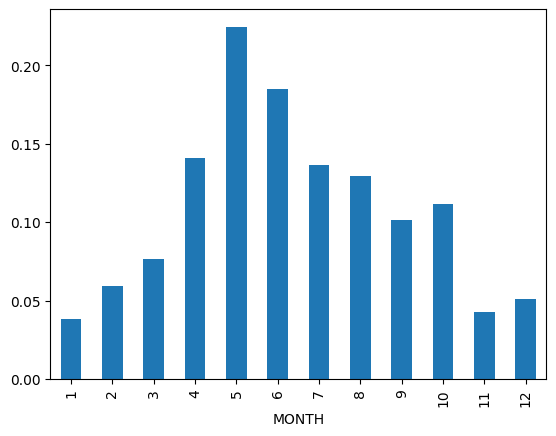

In [ ]:
data.groupby('MONTH')['RAIN'].mean().plot.bar()

#### OKCE has highest rainfall during MAY and JUNE

In [14]:
#Create timestamp
data.Timestamp = pd.to_datetime(data.DATE,format='%d-%m-%Y') 
data.index = data.Timestamp 

In [15]:
data.head()

,RAIN,DATE,MONTH
DATE,,,
2007-04-20,0.00,2007-04-20,4
2007-04-21,0.00,2007-04-21,4
2007-04-22,0.00,2007-04-22,4
2007-04-23,0.00,2007-04-23,4
2007-04-24,0.21,2007-04-24,4


In [16]:
data = data.drop(['DATE','MONTH'], axis=1)

In [17]:
data.head()

,RAIN
DATE,
2007-04-20,0.00
2007-04-21,0.00
2007-04-22,0.00
2007-04-23,0.00
2007-04-24,0.21


# Visualisations

## For OKCE

<Axes: xlabel='DATE'>

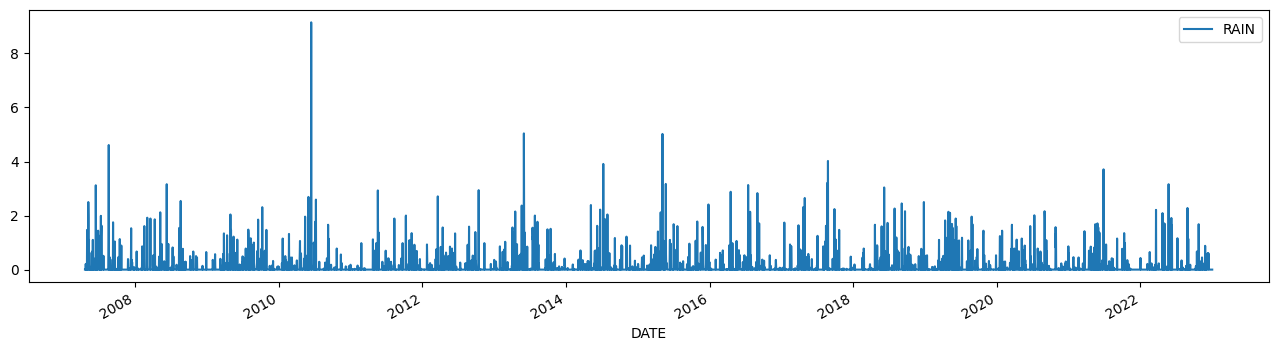

In [ ]:
data.plot(figsize=(16,4))

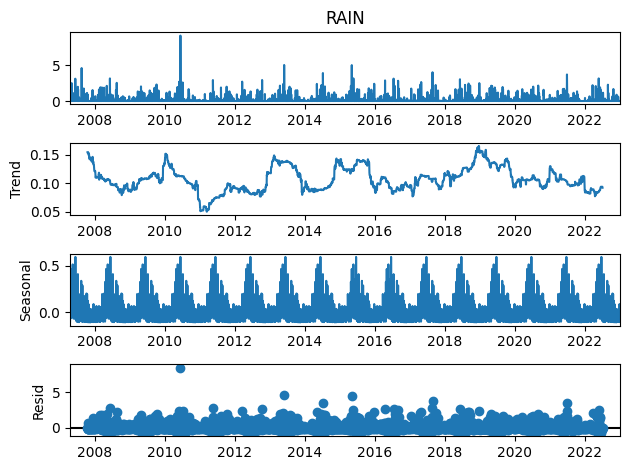

In [ ]:
seasonal_decompose(data['RAIN'], model='additive',period= 365).plot();

### Autocorrelation plot

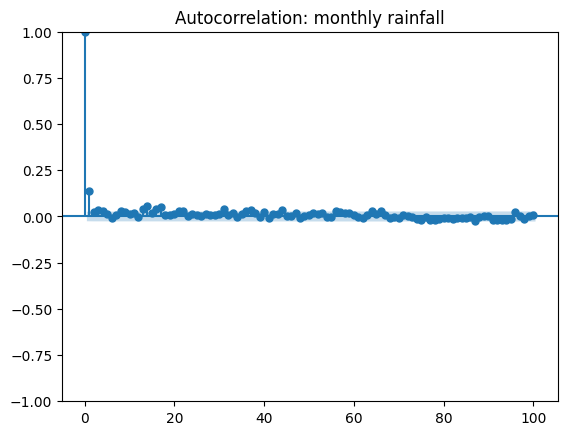

In [ ]:
title = 'Autocorrelation: monthly rainfall'
lags = 100
plot_acf(data,title=title,lags=lags);

#### From the visualization data seems to be seasonal.

### Let's check Stationary of the Time Series using Augmented Dickey-Fuller Test

#### Null hypothesis is that datasets are not stationary

In [ ]:
print('Augmented Dickey-Fuller Test on Rainfall Data')
dftest = adfuller(data['RAIN'],autolag='AIC')

Augmented Dickey-Fuller Test on Rainfall Data


In [ ]:
# extract and print the test results
print('ADF Statistic: {:.4f}'.format(dftest[0]))
print('p-value: {:.4f}'.format(dftest[1]))
print('Lags Used: {}'.format(dftest[2]))
print('Observations Used: {}'.format(dftest[3]))
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t{}: {:.4f}'.format(key, value))

ADF Statistic: -14.9194
p-value: 0.0000
Lags Used: 16
Observations Used: 5709
Critical Values:
	1%: -3.4315
	5%: -2.8620
	10%: -2.5670


#### Since p-value<0.05, we reject the null hypothesis
#### Hence both the datasets are stationary.

In [ ]:
### Train Test Split

In [18]:
len(data)

5726

In [19]:
data.head()

,RAIN
DATE,
2007-04-20,0.00
2007-04-21,0.00
2007-04-22,0.00
2007-04-23,0.00
2007-04-24,0.21


In [20]:
# set the split date
split_date = '2020-01-01'
# select the rows before the split date for the training set
train = data.loc[data.index < split_date]
# select the rows on or after the split date for the testing set
test = data.loc[data.index >= split_date]

In [21]:
len(test), len(train)

(1097, 4629)

# MODELS

## 1. ARIMA

### Checks the best fit model ARIMA to be used along with its parameter

In [ ]:
stepwise_fit = auto_arima(data['RAIN'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5398.518, Time=4.29 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5396.203, Time=0.63 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5285.283, Time=4.00 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5288.022, Time=4.64 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5830.890, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5283.968, Time=0.37 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5285.304, Time=2.96 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5287.532, Time=8.15 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=5285.794, Time=0.71 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5285.657, Time=1.15 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5286.528, Time=0.97 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=5260.687, Time=9.36 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=5265.724, Time=31.73 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=5271.564, Time=25.94 sec
 ARIMA(2,0,1)(1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 5726
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 12)   Log Likelihood               -2622.315
Date:                              Mon, 10 Apr 2023   AIC                           5256.630
Time:                                      02:51:04   BIC                           5296.547
Sample:                                           0   HQIC                          5270.524
                                             - 5726                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.001      2.062      0.039       0.000       0.005
ar.L1          0.9743      0.012     82.325      0.000       0.951       0.997
ma.L1         -0.8375      0.015    -57.673      0.000      -0.866      -0.809
ma.L2         -0.1129      0.008    -13.832      0.000      -0.129      -0.097
ma.S.L12      -0.0272      0.017     -1.599      0.110      -0.060       0.006
sigma2         0.1465      0.001    234.659      0.000       0.145       0.148
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1771793.52
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             6.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Therefore we will use Seasonal-ARIMA model = SARIMAX(1, 0, 2)x(0, 0, 1, 12) for OKCE Rainfall data

In [ ]:
#Fitting our model on Train set

model = SARIMAX(data['RAIN'],order=(1,0,2),seasonal_order=(0,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 RAIN   No. Observations:                 5726
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 12)   Log Likelihood               -2639.165
Date:                              Mon, 10 Apr 2023   AIC                           5288.329
Time:                                      03:30:53   BIC                           5321.593
Sample:                                           0   HQIC                          5299.908
                                             - 5726                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9973      0.001    676.833      0.000       0.994       1.000
ma.L1         -0.8560      0.007   -116.428      0.000      -0.870      -0.842
ma.L2         -0.1184      0.007    -16.523      0.000      -0.132      -0.104
ma.S.L12      -0.0265      0.017     -1.554      0.120      -0.060       0.007
sigma2         0.1472      0.001    269.045      0.000       0.146       0.148
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1718819.93
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             6.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        86.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predicted_a = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,2)(0,0,1,12) Predictions')

In [ ]:
# Compare predictions to expected values
for i in range(len(predicted_a)):
    print(f"predicted={predicted_a[i]}, expected={test['RAIN'][i]}")

predicted=0.043074186584446957, expected=0.0
predicted=0.04221903693627278, expected=0.0
predicted=0.041236790099361965, expected=0.0
predicted=0.04029917364052841, expected=0.0
predicted=0.03938026607676019, expected=0.0
predicted=0.03848192163644661, expected=0.0
predicted=0.037603568561129126, expected=0.0
predicted=0.03673833132853383, expected=0.0
predicted=0.021879888607848945, expected=0.0
predicted=0.03706920117459766, expected=0.05
predicted=0.04138611589226174, expected=0.0
predicted=0.03389348556291108, expected=0.0
predicted=0.03391361685487666, expected=0.0
predicted=0.03304338466369625, expected=0.0
predicted=0.032300797264163704, expected=0.0
predicted=0.03156221129710163, expected=0.6
predicted=0.11561737430506946, expected=1.24
predicted=0.20683823172541027, expected=0.0
predicted=0.04386892584440749, expected=0.0
predicted=0.06204902065472133, expected=0.0
predicted=0.05793675833202351, expected=0.06
predicted=0.06446566550634983, expected=0.36
predicted=0.10712090745

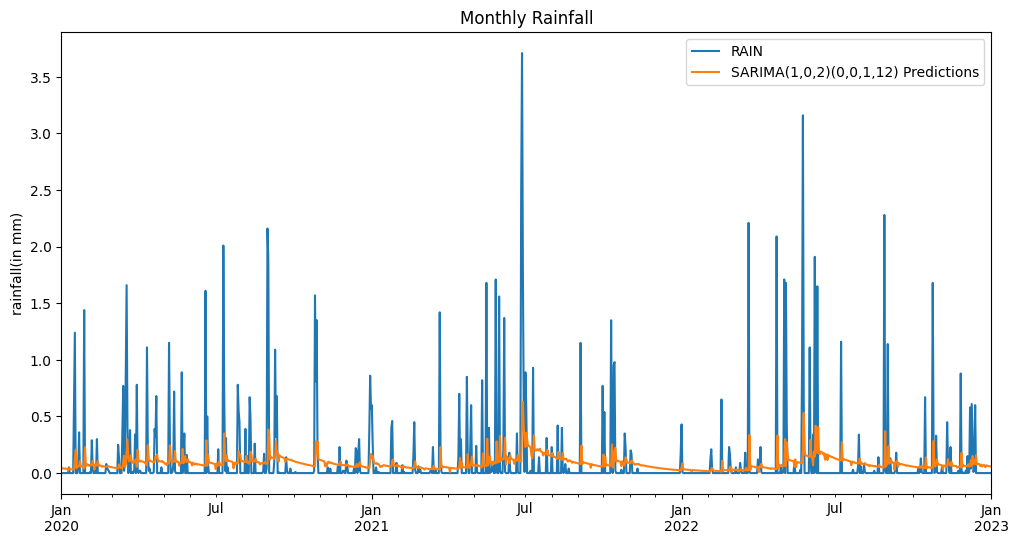

In [ ]:
# Plot predictions against known values
title = 'Monthly Rainfall'
ylabel='rainfall(in mm)'
xlabel=''

ax = test['RAIN'].plot(legend=True,figsize=(12,6),title=title)
predicted_a.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation

In [ ]:
error = rmse(test['RAIN'], predicted_a)
print(f'RMSE Error for ARIMA on OKCE rainfall: {error}')

RMSE Error for ARIMA on OKCE rainfall: 0.33253647281166626


## 2. Deep Learning (LSTM)

In [ ]:
#Scaled the data
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit_generator(generator,epochs=10)

Epoch 1/10
4605/4605 [==============================] - 60s 13ms/step - loss: 0.0019
Epoch 2/10
4605/4605 [==============================] - 57s 12ms/step - loss: 0.0019
Epoch 3/10
4605/4605 [==============================] - 56s 12ms/step - loss: 0.0019
Epoch 4/10
4605/4605 [==============================] - 58s 13ms/step - loss: 0.0019
Epoch 5/10
4605/4605 [==============================] - 56s 12ms/step - loss: 0.0019
Epoch 6/10
4605/4605 [==============================] - 57s 12ms/step - loss: 0.0019
Epoch 7/10
4605/4605 [==============================] - 56s 12ms/step - loss: 0.0019
Epoch 8/10
4605/4605 [==============================] - 57s 12ms/step - loss: 0.0019
Epoch 9/10
4605/4605 [==============================] - 58s 13ms/step - loss: 0.0019
Epoch 10/10
4605/4605 [==============================] - 57s 12ms/step - loss: 0.0019


In [ ]:
model.history.history.keys()

dict_keys(['loss'])

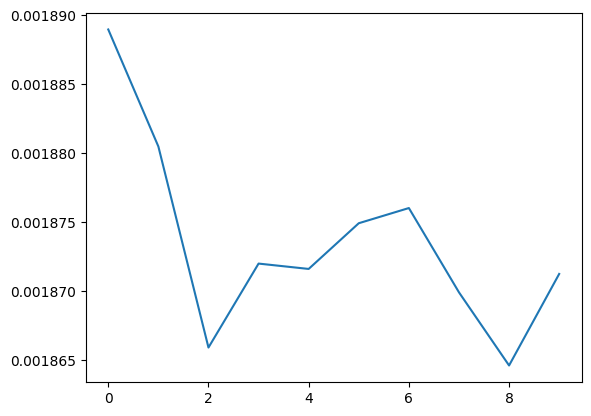

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [ ]:
test_predictions

[array([0.00970658], dtype=float32),
 array([0.01042842], dtype=float32),
 array([0.01001716], dtype=float32),
 array([0.01014338], dtype=float32),
 array([0.01005841], dtype=float32),
 array([0.01007944], dtype=float32),
 array([0.01006124], dtype=float32),
 array([0.01006421], dtype=float32),
 array([0.01006008], dtype=float32),
 array([0.01006027], dtype=float32),
 array([0.01005925], dtype=float32),
 array([0.01005914], dtype=float32),
 array([0.01005886], dtype=float32),
 array([0.01005878], dtype=float32),
 array([0.0100587], dtype=float32),
 array([0.01005866], dtype=float32),
 array([0.01005863], dtype=float32),
 array([0.01005861], dtype=float32),
 array([0.0100586], dtype=float32),
 array([0.01005858], dtype=float32),
 array([0.01005859], dtype=float32),
 array([0.01005854], dtype=float32),
 array([0.01005854], dtype=float32),
 array([0.01005855], dtype=float32),
 array([0.01005856], dtype=float32),
 array([0.01005856], dtype=float32),
 array([0.01005856], dtype=float32),
 ar

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test = test
test['Predictions'] = true_predictions

In [ ]:
test

,RAIN,Predictions
DATE,,
2020-01-01,0.0,0.088815
2020-01-02,0.0,0.095420
2020-01-03,0.0,0.091657
2020-01-04,0.0,0.092812
2020-01-05,0.0,0.092034
...,...,...
2022-12-28,0.0,0.092036
2022-12-29,0.0,0.092036
2022-12-30,0.0,0.092036


<Axes: xlabel='DATE'>

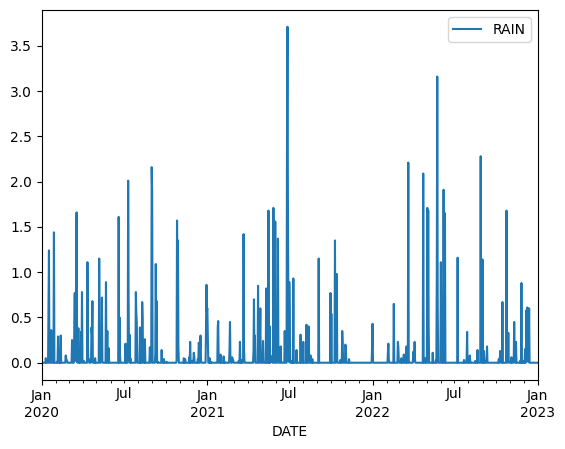

In [ ]:
test.plot(y='RAIN')

<Axes: xlabel='DATE'>

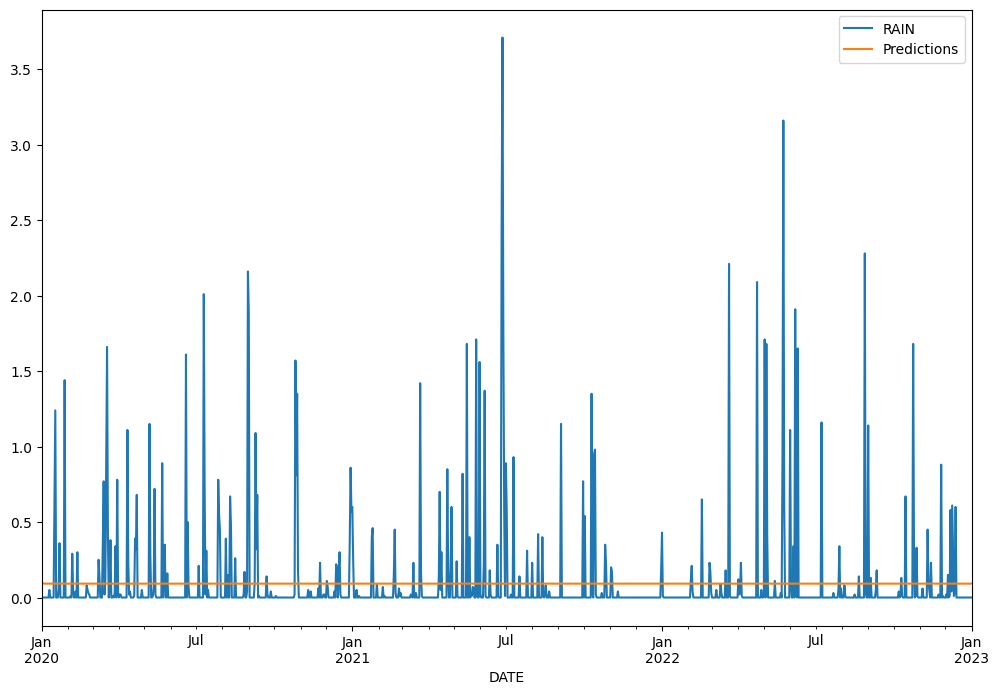

In [ ]:
test.plot(figsize=(12,8))

#### Evaluation

In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['RAIN'], test['Predictions'])
print(error)

0.33981819315229617


In [ ]:
test_a = test_a.drop(['Predictions'], axis=1)
test_j = test_j.drop(['Predictions'], axis=1)

#### Evaluation

## 3. Holt's Winter Method (Triple Exponential Smoothing)

In [22]:
print(data.index.freq)

None


In [23]:
data = data.asfreq(freq='D')
data.index

DatetimeIndex(['2007-04-20', '2007-04-21', '2007-04-22', '2007-04-23',
               '2007-04-24', '2007-04-25', '2007-04-26', '2007-04-27',
               '2007-04-28', '2007-04-29',
               ...
               '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
               '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
               '2022-12-31', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=5736, freq='D')

In [24]:
fitted_model = ExponentialSmoothing(train['RAIN'],trend='add',seasonal='add',seasonal_periods=12).fit()

In [25]:
test_predictions = fitted_model.forecast(24).rename('HW Forecast')

In [26]:
test_predictions

4629    0.041880
4630    0.031531
4631    0.086443
4632    0.035024
4633    0.061373
4634    0.068735
4635    0.029781
4636    0.024446
4637    0.052820
4638    0.057750
4639    0.047418
4640    0.049217
4641    0.041358
4642    0.031010
4643    0.085922
4644    0.034502
4645    0.060852
4646    0.068214
4647    0.029260
4648    0.023925
4649    0.052298
4650    0.057229
4651    0.046896
4652    0.048696
Name: HW Forecast, dtype: float64

In [ ]:
test['RAIN'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.index = pd.to_datetime(test_predictions.index, unit='s')
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluation

In [ ]:
np.sqrt(mean_squared_error(test_a,test_predictions))

# RESULTS